In [1]:
import itertools
import importlib
from functools import reduce
import operator

import pennylane as qml
from pennylane import numpy as np
import numpy as nnp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

from silence_tensorflow import silence_tensorflow
# tf.keras.backend.set_floatx('bfloat32')

In [2]:
import warnings
import traceback

warnings.simplefilter("error")
warnings.simplefilter("once", category=qml.PennyLaneDeprecationWarning)

In [3]:
from src.layers import *

In [4]:
SEED = 42
np.random.seed(SEED)
# torch.manual_seed(42)
tf.random.set_seed(SEED)

# Data Generation

In [5]:
def generate_dataset_4(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical horizontal left diagonal or right diagonal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.25:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(0)  # Label for vertical line
        elif np.random.rand() < 0.5:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1)
        elif np.random.rand() < 0.75:
            # Left diagonal line
            for j in range(size):
                image[j, j] = 255
            labels.append(2)
        else:
            # Right diagonal line
            for j in range(size):
                image[j, size - j - 1] = 255
            labels.append(3)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    labels = np.array(labels)
    labels = np.eye(4)[labels]
    return np.array(images), np.array(labels)

def generate_dataset_2(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical or horizontal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.5:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(-1.0)  # Label for vertical line
        else:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1.0)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    # labels = np.array(labels)
    # labels = np.eye(2)[labels]
    return np.array(images), np.array(labels).astype(np.float32)

In [6]:
images, labels = generate_dataset_2(150, noise=0.05)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)
# conver them to tensors


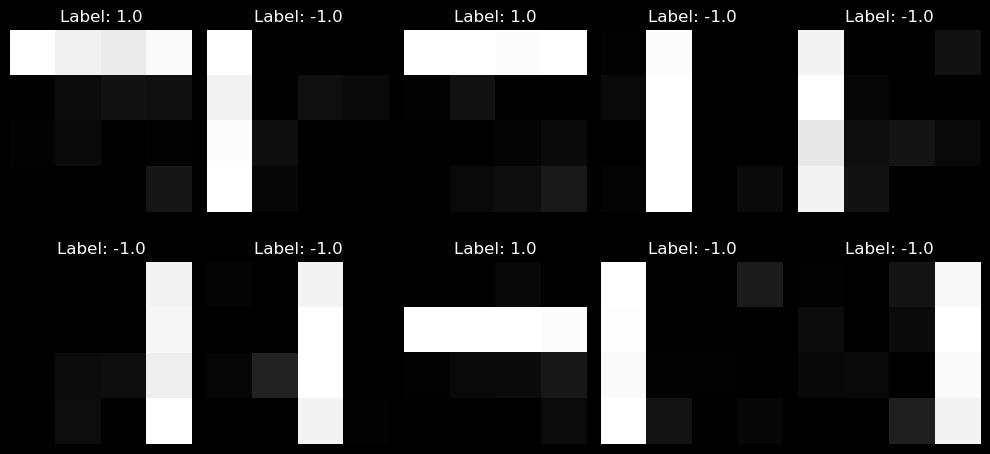

In [7]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(train_images.shape[1], train_images.shape[2]), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
train_images, train_labels = tf.convert_to_tensor(train_images), tf.convert_to_tensor(train_labels)
test_images, test_labels = tf.convert_to_tensor(test_images), tf.convert_to_tensor(test_labels)

2025-05-15 21:20:35.901186: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-15 21:20:35.901221: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-15 21:20:35.901251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1747358435.901277 1559316 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747358435.901334 1559316 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Creating Circuit

In [9]:
assert train_images.shape[1] == train_images.shape[2], "Images must be square"
N = train_images.shape[1]
B = 4
dev = qml.device("default.qubit", wires=N * N + B)
wire_arr = nnp.arange(N * N).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 2
STRIDE = 1

In [10]:
@qml.qnode(dev)
def qnode(inputs, 
          first_kernel, first_pooling, 
          second_kernel, second_pooling, 
          # fc_weights, fc_bias
):
    # Input Layer
    for i, j in itertools.product(range(N), range(N)):
        qml.RX(1.0 * np.pi * inputs[i, j], wires=wire_arr[i, j])
    
    # First Convolution Layer    
    convolution_pooling_op(first_kernel, first_pooling, wire_arr, STRIDE)
    reduced_wire_arr = wire_arr[1::2, 1::2]
    
    # Second Convolution Layer
    convolution_pooling_op(second_kernel, second_pooling, reduced_wire_arr, STRIDE)
    reduced_wire_arr = reduced_wire_arr[1::2, 1::2]
    
    # Fully Connected Layer
    # fully_connected_op(fc_weights, fc_bias, reduced_wire_arr.flatten().tolist(), list(range(N*N, N*N + B)))
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in reduced_wire_arr.flatten().tolist()]
    # return [qml.probs(i) for i in reduced_wire_arr.flatten().tolist()]

In [11]:
weight_shapes = {
    "first_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "first_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    "second_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "second_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    # "fc_weights": (B - 1, B),
    # "fc_bias": (B,),
}

qlayer = PatchedKerasLayer(qnode, weight_shapes, output_dim=(1,))
{name: (reduce(operator.mul, x.shape), x.shape) for name, x in qlayer.qnode_weights.items()}, qlayer

/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.10/site-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


({'first_kernel': (8, TensorShape([2, 2, 2])),
  'first_pooling': (4, TensorShape([2, 2])),
  'second_kernel': (8, TensorShape([2, 2, 2])),
  'second_pooling': (4, TensorShape([2, 2]))},
 <Quantum Keras Layer: func=qnode>)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N)),
    qlayer,
    # tf.keras.layers.Lambda(prob_extraction),
])
# model.load_weights('line_model.keras')

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.025)
model.compile(opt, loss="MSE", metrics=[custom_accuracy])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patched_keras_layer             │ (None, 1)              │            24 │
│ (PatchedKerasLayer)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Test the forward pass with a batch of training images
sample_output = model(train_images[:5])  # Pass the first 3 training images
print("Sample output shape:", sample_output.shape)
print("Sample output:", sample_output.numpy(), train_labels[:5])

Sample output shape: (1, 5)
Sample output: [[ 0.02729531 -0.10849536  0.02598418 -0.06261391 -0.10627695]] tf.Tensor([ 1. -1.  1. -1. -1.], shape=(5,), dtype=float32)


# Model Training

In [15]:
silence_tensorflow("ERROR")
fitting = model.fit(train_images, train_labels, epochs=4, batch_size=16, validation_data=(test_images, test_labels), verbose=1, shuffle=True)

Epoch 1/4
35/35 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - custom_accuracy: 0.7702 - loss: 0.9731 - val_custom_accuracy: 0.9111 - val_loss: 0.8753
Epoch 2/4
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - custom_accuracy: 0.9535 - loss: 0.8497 - val_custom_accuracy: 1.0000 - val_loss: 0.8183
Epoch 3/4
35/35 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - custom_accuracy: 1.0000 - loss: 0.8037 - val_custom_accuracy: 1.0000 - val_loss: 0.7949
Epoch 4/4
35/35 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - custom_accuracy: 1.0000 - loss: 0.7826 - val_custom_accuracy: 1.0000 - val_loss: 0.7918


In [16]:
model.get_weights()[0]

array([[[ 0.11613654, -0.13755006],
        [ 0.0724539 , -0.790224  ]],

       [[ 0.16803056,  0.6093633 ],
        [-0.59715074,  0.11533863]]], dtype=float32)

In [ ]:
model.save("models/line_model.keras")